In [6]:
from pycbc.waveform import get_td_waveform
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
from pycbc.filter import sigma
import numpy
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
from pycbc.detector import Detector
from pycbc.filter import matched_filter, resample_to_delta_t, highpass
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation
import numpy

In [7]:
m1 = 10
m2 = m1
freq = 4096

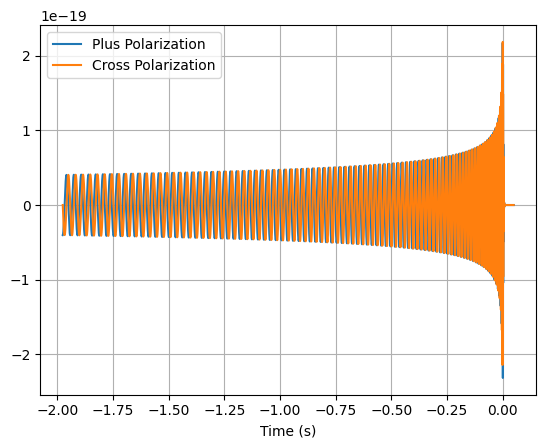

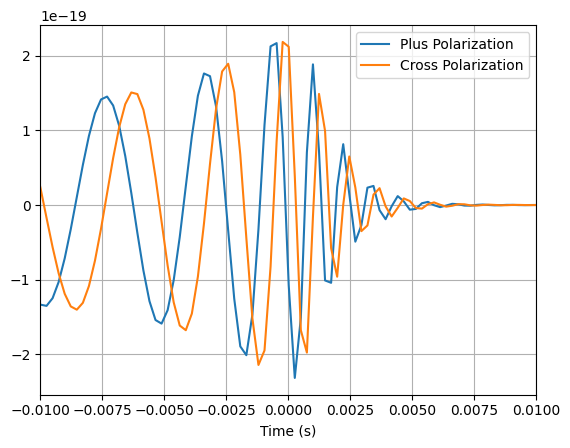

In [11]:
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(
    approximant="IMRPhenomT", mass1=m1, mass2=m2, delta_t=1.0 / freq, f_lower=30
)

pylab.plot(hp.sample_times, hp, label="Plus Polarization")
pylab.plot(hp.sample_times, hc, label="Cross Polarization")
pylab.xlabel("Time (s)")
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label="Plus Polarization")
pylab.plot(hp.sample_times, hc, label="Cross Polarization")
pylab.xlabel("Time (s)")
pylab.xlim(-0.01, 0.01)
pylab.legend()
pylab.grid()
pylab.show()

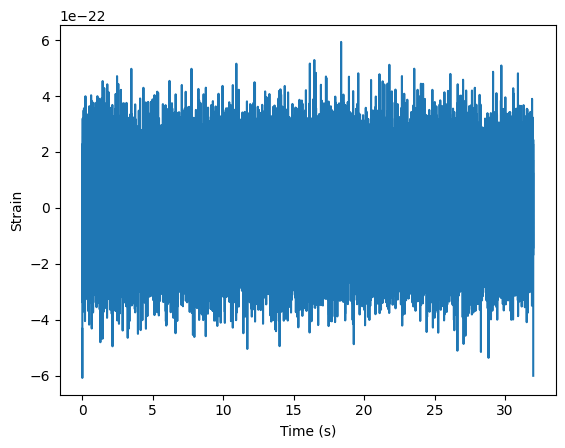

In [17]:
flow = 30.0
delta_f = 1.0 / freq
flen = int(freq / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / freq
tsamples = int(32 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

strain = resample_to_delta_t(highpass(ts, 15.0), 1.0 / 2048)

pp.plot(strain.sample_times, strain)
pp.ylabel("Strain")
pp.xlabel("Time (s)")
pp.show()

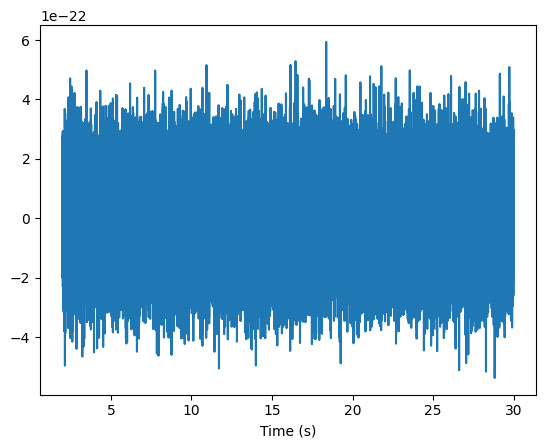

In [18]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel("Time (s)")
pylab.show()

(30, 1024)

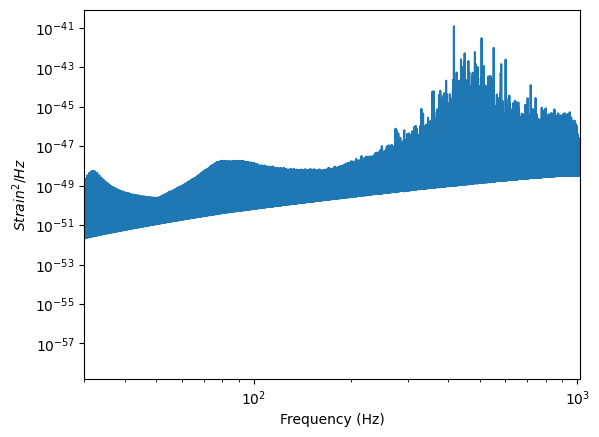

In [19]:
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(
    psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=10
)

pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel("$Strain^2 / Hz$")
pylab.xlabel("Frequency (Hz)")
pylab.xlim(30, 1024)

In [14]:
print(len(conditioned))

114688


In [22]:
snr_peak_values = []
m_values = []

# FILEPATH: /home/arush/GW_Test_1/snr.ipynb
snr_peak = 0
m = 9  # Solar masses
while snr_peak < 25 and m < 400:
    m += 1
    hp, hc = get_td_waveform(
        approximant="SEOBNRv4_opt",  # SEOBNRv4_opt
        mass1=m,
        mass2=m,
        delta_t=conditioned.delta_t,
        f_lower=20,
        distance=100,
    )

    template = hp.cyclic_time_shift(hp.start_time)

    # We will resize the vector to match our data
    hp.resize(len(conditioned))
    print("after resize: ", len(hp))

    template = hp.cyclic_time_shift(hp.start_time)

    peak = hp.numpy().argmax()
    # print("peak", hp[peak])
    snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)

    snr = snr.crop(4 + 4, 4)

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
    snr_peak = abs(snrp)
    print("mass = ", m)
    print("We found a signal at {}s with SNR {}".format(time, snr_peak))

    # Append the values to the lists
    snr_peak_values.append(snr_peak)
    m_values.append(m)

after resize:  57344
mass =  10
We found a signal at 10.0693359375s with SNR 229.06483570255833


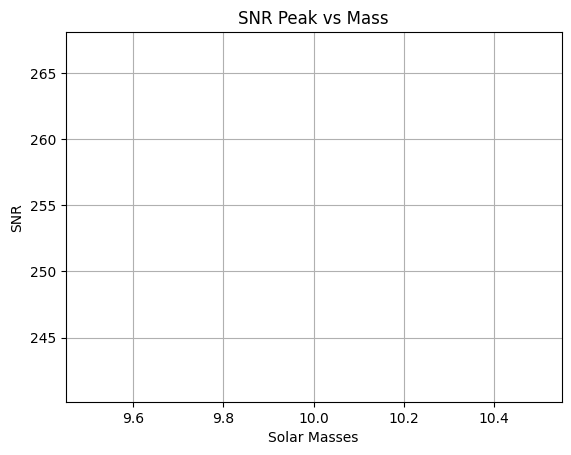

The SNR peak is:  254.11967931481658
The mass is:  10


In [16]:
# Plot snr_peak vs m
pylab.plot(m_values, snr_peak_values)
pylab.xlabel("Solar Masses")
pylab.ylabel("SNR")
pylab.title("SNR Peak vs Mass")
pylab.grid()
pylab.show()
print("The SNR peak is: ", max(snr_peak_values))
print("The mass is: ", m_values[snr_peak_values.index(max(snr_peak_values))])

In [ ]:
snr_peak_values = []
d_values = []


snr_peak = 0
m = 20  # Solar masses
d = 50
while snr_peak < 25 and d < 1000:
    d += 10
    hp, hc = get_td_waveform(
        approximant="IMRPhenomT",
        mass1=m,
        mass2=m,
        delta_t=conditioned.delta_t,
        f_lower=20,
        distance=d,
    )

    template = hp.cyclic_time_shift(hp.start_time)

    # We will resize the vector to match our data
    hp.resize(len(conditioned))
    print("after resize: ", len(hp))

    template = hp.cyclic_time_shift(hp.start_time)

    peak = hp.numpy().argmax()
    # print("peak", hp[peak])
    snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)

    # sigma()

    snr = snr.crop(4 + 4, 4)

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
    snr_peak = abs(snrp)
    print("distance = ", d)
    print("We found a signal at {}s with SNR {}".format(time, snr_peak))

    # Append the values to the lists
    snr_peak_values.append(snr_peak)
    d_values.append(d)

after resize:  57344
distance =  60
We found a signal at 1126259462.4291992s with SNR 9.638867353428967
after resize:  57344
distance =  70
We found a signal at 1126259462.4291992s with SNR 9.638867353428969
after resize:  57344
distance =  80
We found a signal at 1126259462.4291992s with SNR 9.63886735342897
after resize:  57344
distance =  90
We found a signal at 1126259462.4291992s with SNR 9.63886735342897
after resize:  57344
distance =  100
We found a signal at 1126259462.4291992s with SNR 9.638867353428969
after resize:  57344
distance =  110
We found a signal at 1126259462.4291992s with SNR 9.63886735342897
after resize:  57344
distance =  120
We found a signal at 1126259462.4291992s with SNR 9.63886735342897
after resize:  57344
distance =  130
We found a signal at 1126259462.4291992s with SNR 9.63886735342897
after resize:  57344
distance =  140
We found a signal at 1126259462.4291992s with SNR 9.638867353428969
after resize:  57344
distance =  150
We found a signal at 112625

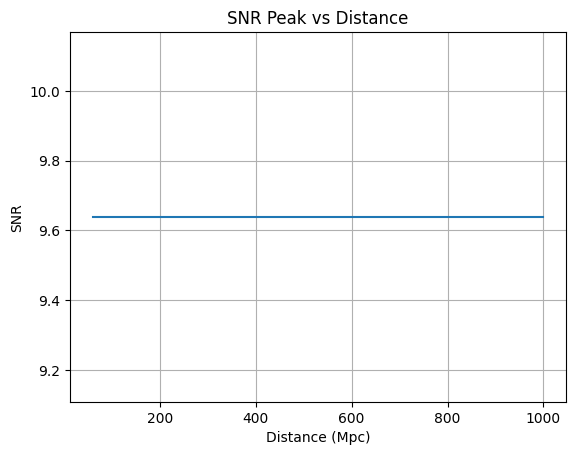

The SNR peak is:  9.638867353428974
At Distance:  510


In [ ]:
# Plot snr_peak vs m
pylab.plot(d_values, snr_peak_values)
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("SNR")
pylab.title("SNR Peak vs Distance")
pylab.grid()
pylab.show()
print("The SNR peak is: ", max(snr_peak_values))
print("At Distance: ", d_values[snr_peak_values.index(max(snr_peak_values))])

In [ ]:
# ##  MATCHED FILTERING:

# # The time, amplitude, and phase of the SNR peak tell us how to align

# # our proposed signal with the data.

# # Shift the template to the peak time

# dt = time - conditioned.start_time
# aligned = template.cyclic_time_shift(dt)

# # scale the template so that it would have SNR 1 in this data

# aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# # Scale the template amplitude and phase to the peak value

# aligned = (aligned.to_frequencyseries() \* snrp).to_timeseries()
# aligned.start_time = conditioned.start_time

# # We do it this way so that we can whiten both the template and the data

# white_data = (conditioned.to_frequencyseries() / psd\*\*0.5).to_timeseries()

# # apply a smoothing of the turnon of the template to avoid a transient

# # from the sharp turn on in the waveform.

# tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
# white_template = (tapered.to_frequencyseries() / psd\*\*0.5).to_timeseries()

# white_data = white_data.highpass_fir(30.0, 512).lowpass_fir(300, 512)
# white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# # Select the time around the merger

# white_data = white_data.time_slice(merger.time - 0.2, merger.time + 0.1)
# white_template = white_template.time_slice(merger.time - 0.2, merger.time + 0.1)

# pylab.figure(figsize=[15, 3])
# pylab.plot(white_data.sample_times, white_data, label="Data")
# pylab.plot(white_template.sample_times, white_template, label="Template")
# pylab.legend()
# pylab.show()